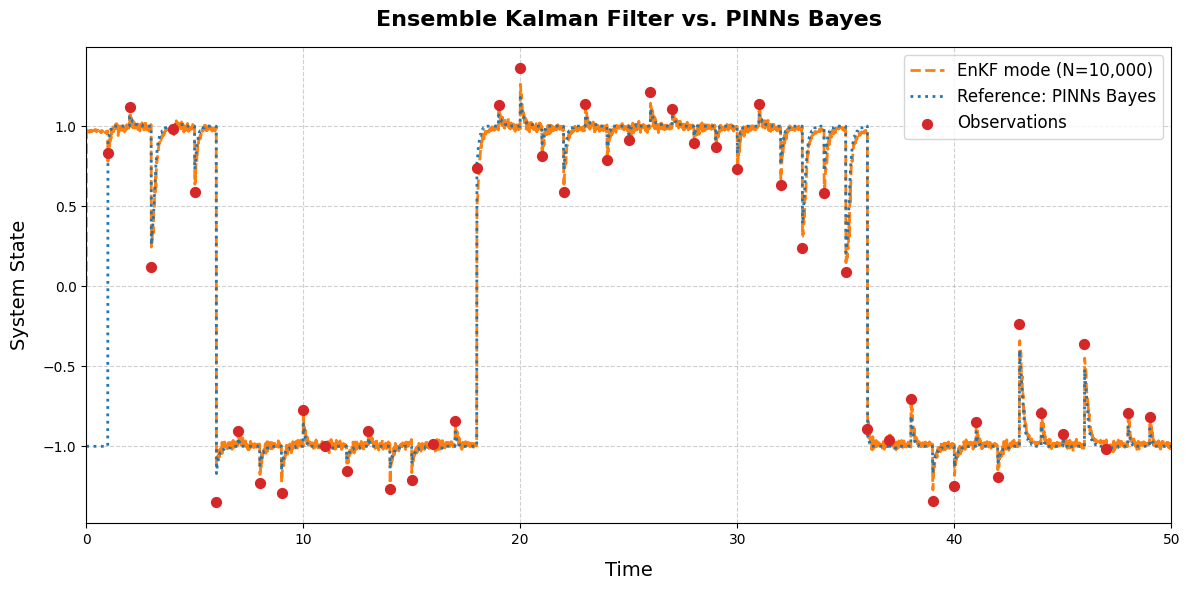

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

observations = np.load("Obs_doublewell_k=0.9.npy")
observation_times = np.load("Obs_time_doublewell_k=0.9.npy")
mcmc_initial = np.load("samples10000.npy")
PINNs_Bayes = np.load("pinn_bayes_solutions_0_50_k_0.9_1.npy")
grid_points = 401
domain_bound = 2
spatial_grid = np.linspace(-domain_bound, domain_bound, grid_points)
reference_modes = spatial_grid[np.argmax(PINNs_Bayes, axis=0)]

def drift(state):
    return 4 * state - 4 * state**3

def simulate_sde(noise_strength, final_time, time_step, initial_state):
    steps = int(final_time / time_step)
    trajectory = np.zeros(steps)
    trajectory[0] = initial_state
    noise = np.random.normal(0, np.sqrt(time_step), size=steps)
    for i in range(1, steps):
        trajectory[i] = trajectory[i-1] + drift(trajectory[i-1]) * time_step + noise_strength * noise[i-1]
    return trajectory

def initialize_ensembles(num_ensembles):
    return np.random.normal(0, 0.4, size=num_ensembles)

def forecast(ensembles, noise_strength, time_step):
    noise = np.random.normal(0, np.sqrt(time_step), size=len(ensembles))
    return ensembles + drift(ensembles) * time_step + noise_strength * noise

def perturb_observation(num_ensembles, obs_error_var, observation):
    noise = np.random.normal(0, np.sqrt(obs_error_var), size=num_ensembles)
    return observation + noise

def compute_mode_and_ci(states, bandwidth='scott', confidence=0.68):
    density = gaussian_kde(states, bw_method=bandwidth)
    eval_points = np.linspace(min(states), max(states), 1000)
    density_vals = density(eval_points)
    mode = eval_points[np.argmax(density_vals)]
    peak_val = density_vals[np.argmax(density_vals)]
    threshold = peak_val * confidence
    ci_lower = eval_points[np.where(density_vals >= threshold)[0][0]]
    ci_upper = eval_points[np.where(density_vals >= threshold)[0][-1]]
    return mode, (ci_lower, ci_upper)

def compute_mean_and_ci(states, confidence=0.68):
    mean = np.mean(states)
    std = np.std(states)
    std_error = std / np.sqrt(len(states))
    z_score = 1.0 if confidence == 0.68 else 1.96
    margin = z_score * std_error
    return mean, (mean - margin, mean + margin)

time_step = 0.01
final_time = 50
initial_state = 0.0
noise_strength = 0.9
num_ensembles = 10000
obs_error_var = 0.04
total_steps = int(final_time / time_step)
obs_frequency = 100

ensembles = mcmc_initial
positions = np.zeros((total_steps, num_ensembles))
positions[0] = ensembles
means = np.zeros(total_steps)
modes = np.zeros(total_steps)
mode_ci_lower = np.zeros(total_steps)
mode_ci_upper = np.zeros(total_steps)
means[0] = np.mean(ensembles)
mean_ci_lower = np.zeros(total_steps)
mean_ci_upper = np.zeros(total_steps)
stds = np.zeros(total_steps)

for t in range(1, total_steps):
    ensembles = forecast(ensembles, noise_strength, time_step)
    positions[t] = ensembles
    
    if t % obs_frequency == 0:
        obs_idx = t // obs_frequency
        obs = observations[obs_idx]
        perturbed_obs = perturb_observation(num_ensembles, obs_error_var, obs)
        ensemble_mean = np.mean(ensembles)
        error = ensembles - ensemble_mean
        covariance = np.var(error, ddof=1)
        kalman_gain = covariance / (covariance + obs_error_var)
        ensembles = ensembles + kalman_gain * (perturbed_obs - ensembles)
    
    stds[t] = np.std(ensembles)
    means[t] = np.mean(ensembles)
    mode, mode_ci = compute_mode_and_ci(ensembles)
    modes[t] = mode
    mode_ci_lower[t] = mode_ci[0]
    mode_ci_upper[t] = mode_ci[1]
    mean, mean_ci = compute_mean_and_ci(ensembles)
    means[t] = mean
    mean_ci_lower[t] = mean_ci[0]
    mean_ci_upper[t] = mean_ci[1]

plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, final_time, total_steps)
plt.plot(time_axis, modes, label="EnKF mode (N=10,000)", color="#ff7f0e", linestyle="--", linewidth=2)
plt.plot(time_axis, reference_modes, label="Reference: PINNs Bayes", color="#1f77b4", linestyle=":", linewidth=2)
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#d62728", s=50, zorder=2)
plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("Ensemble Kalman Filter vs. PINNs Bayes", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("Mode_Comparison_PINNs_Bayes_EnKF.png", dpi=300, bbox_inches="tight")
plt.show()

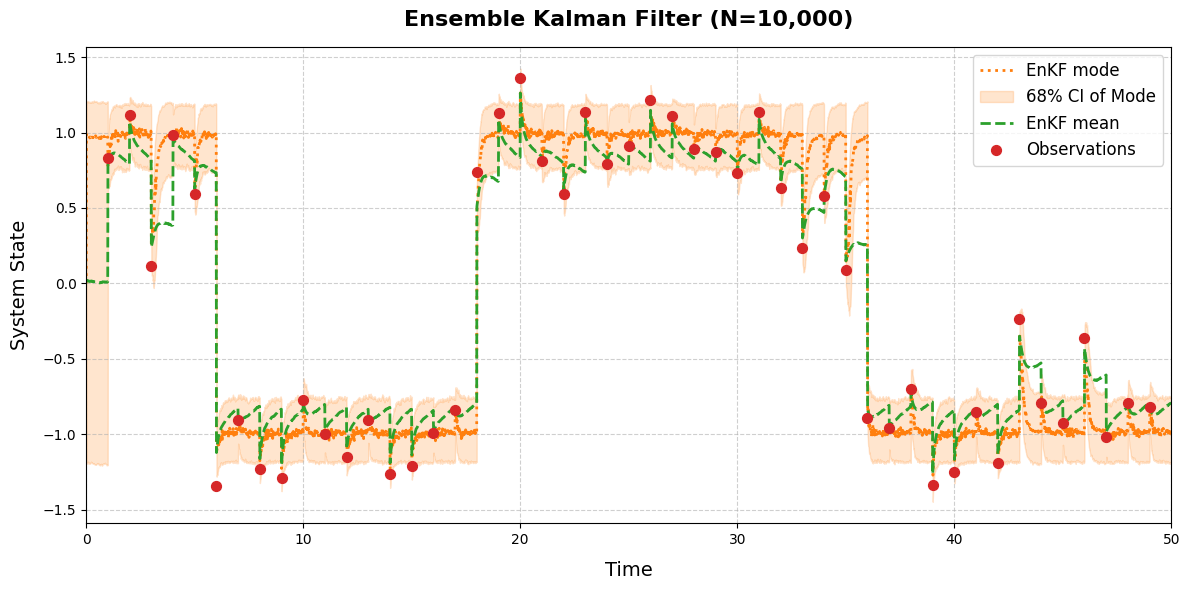

In [2]:
plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, final_time, total_steps)
plt.plot(time_axis, modes, label="EnKF mode", color="#ff7f0e", linestyle=":", linewidth=2)
plt.fill_between(time_axis, mode_ci_lower, mode_ci_upper, color="#ff7f0e", alpha=0.2, label="68% CI of Mode")
plt.plot(time_axis, means, label="EnKF mean", color="#2ca02c", linestyle="--", linewidth=2)
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#d62728", s=50, zorder=2)
plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("Ensemble Kalman Filter (N=10,000)", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("Mode_and_Mean_EnKF.png", dpi=300, bbox_inches="tight")
plt.show()